# Spatial DATA Analysis

- Ceate a simple plot of the region centroids.
- Generate an interactive Folium map where the size of each point represents the consumption
- Perform a nearest neighbor analysis to explore spatial relationships in consumption
- Create time series plots for each region

In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from shapely.geometry import Point

In [21]:
def clean_data(df):
    # Convert année to datetime
    df['annee'] = pd.to_datetime(df['annee'], format='%Y')
    
    #converting consumption to numeric replacing , with .
    df['consommation_gwh_pcs'] = pd.to_numeric(df['consommation_gwh_pcs'].replace(',', '.'))
    
    # Parse 'centroid'
    def parse_centroid(centroid_str):
        try:
            x, y = map(float, centroid_str.split(','))
            return Point(x, y)  # (x, y) = longitude, latitude
        except:
            return None

    df['geometry'] = df['centroid'].apply(parse_centroid)
    
    #remove rows with missing values
    df = df.dropna()
    
    return df

In [4]:
# load the data
df = pd.read_csv('consommation-regionale-cleaned.csv')

In [7]:
# Clean the data
df = clean_data(df)

In [22]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [10]:
# Set the coordinate reference system (CRS) to EPSG:4326 (WGS84)
gdf = gdf.set_crs("EPSG:4326")
gdf

,Unnamed: 0,annee,code_insee_region,region,consommation_kwh_pcs,consommation_gwh_pcs,geom,centroid,date,geometry
0,0,2017-01-01,84,Auvergne-Rhône-Alpes,8.360393e+07,83.603928,"{""coordinates"": [[[[2.281089687, 46.420473176]...","45.514642251,4.536120089",2017-01-01,POINT (4.53612 45.51464)
1,1,2017-01-01,32,Hauts-de-France,2.000740e+08,200.073972,"{""coordinates"": [[[[3.485019233, 48.851845323]...","49.969594242,2.771302607",2017-01-01,POINT (2.7713 49.96959)
2,2,2018-01-01,53,Bretagne,2.174825e+07,21.748245,"{""coordinates"": [[[[-3.427415232, 47.641033313...","48.177553833,-2.841491226",2018-01-01,POINT (-2.84149 48.17755)
3,3,2018-01-01,52,Pays de la Loire,1.334686e+08,133.468606,"{""coordinates"": [[[[-2.337432985, 46.719095681...","47.478103854,-0.816788614",2018-01-01,POINT (-0.81679 47.4781)
4,4,2019-01-01,84,Auvergne-Rhône-Alpes,1.623392e+08,162.339222,"{""coordinates"": [[[[2.281089687, 46.420473176]...","45.514642251,4.536120089",2019-01-01,POINT (4.53612 45.51464)
...,...,...,...,...,...,...,...,...,...,...
103,103,2020-01-01,93,Provence-Alpes-Côte d'Azur,4.321210e+07,43.212096,"{""coordinates"": [[[[6.506367702, 43.043784724]...","43.958770072,6.061003389",2020-01-01,POINT (6.061 43.95877)
104,104,2021-01-01,24,Centre-Val de Loire,1.427772e+07,14.277721,"{""coordinates"": [[[[1.501397407, 48.941034037]...","47.484775714,1.68439107",2021-01-01,POINT (1.68439 47.48478)
105,105,2021-01-01,75,Nouvelle-Aquitaine,2.261687e+08,226.168683,"{""coordinates"": [[[[-1.412478526, 46.184385107...","45.206040306,0.21271768",2021-01-01,POINT (0.21272 45.20604)
106,106,2022-01-01,84,Auvergne-Rhône-Alpes,3.741228e+08,374.122820,"{""coordinates"": [[[[2.281089687, 46.420473176]...","45.514642251,4.536120089",2022-01-01,POINT (4.53612 45.51464)


## Spatial Analysis

<Figure size 1500x1000 with 0 Axes>

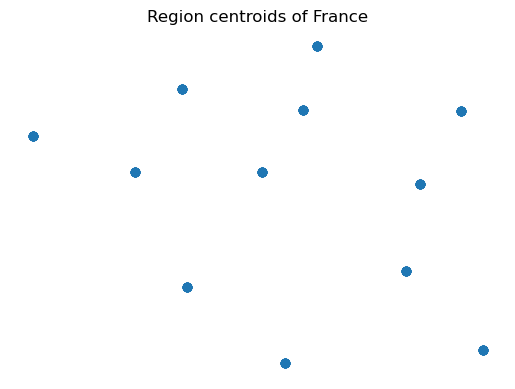

In [23]:
# 1 Plot a simple map of centroids
plt.figure(figsize=(15, 10))
gdf.plot()
plt.title('Region centroids of France')
plt.axis('off')
plt.show()

In [13]:
# 2 Create an interactive map using Folium
def create_interactive_map(year):
    data = gdf[gdf['annee'].dt.year == year]
    
    m = folium.Map(location=[46.2276, 2.2137], zoom_start=6)

    for idx, row in data.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=row['consommation_gwh_pcs'] / 10,  # Adjust this factor as needed
            popup=f"{row['region']}: {row['consommation_gwh_pcs']:.2f} GWh",
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(m)

    return m

In [14]:
# Create an interactive map for 2019
map_2019 = create_interactive_map(2019)
map_2019.save('france_gas_consumption_2019_centroids.html')

In [15]:
# Create an interactive map for 2020
map_2020 = create_interactive_map(2020)
map_2020.save('france_gas_consumption_2020_centroids.html')

In [25]:
# 3 Spatial analysis: Calculate nearest neighbors
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(gdf, n_neighbors=3):
    # Extracting coordinates
    coords = gdf[['geometry']].apply(lambda x: [x.geometry.x, x.geometry.y], axis=1).tolist()
    
    # Fit
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    nn.fit(coords)
    
    # nearest neighbors
    distances, indices = nn.kneighbors(coords)
    
    return distances, indices

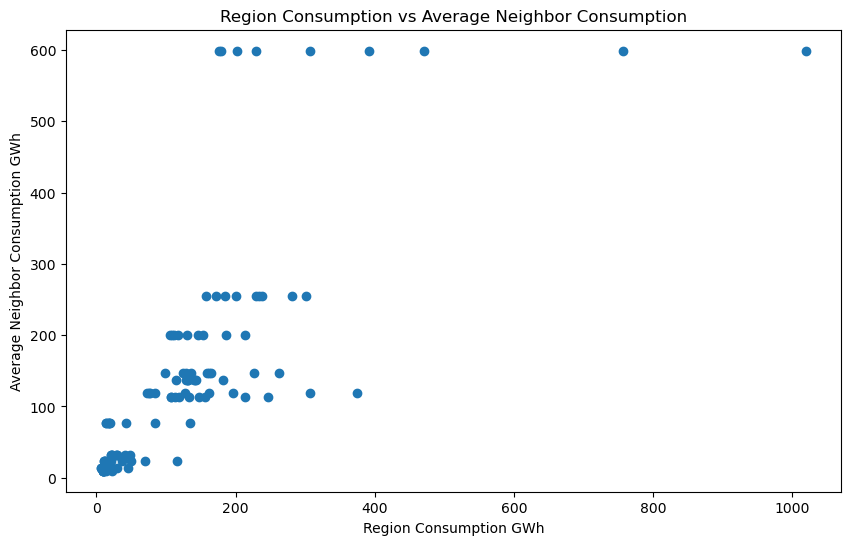

In [26]:
# Find nearest neighbors
distances, indices = find_nearest_neighbors(gdf)

# Add average neighbor consumption to the dataframe
gdf['avg_neighbor_consumption'] = gdf.apply(lambda row: gdf.iloc[indices[row.name][1:]]['consommation_gwh_pcs'].mean(), axis=1)

# Plot relationship between regions consumption and average neighbor consumption
plt.figure(figsize=(10, 6))
plt.scatter(gdf['consommation_gwh_pcs'], gdf['avg_neighbor_consumption'])
plt.xlabel('Region Consumption GWh')
plt.ylabel('Average Neighbor Consumption GWh')
plt.title('Region Consumption vs Average Neighbor Consumption')
plt.show()


## Plot Analysis
- There appears to be a strong positive correlation between a region's consumption and the average consumption of its neighboring regions. As one increases, the other tends to increase as well
- Clusters are formed: 
    - Large cluster in the lower left (low consumption regions)
    - A Smaller cluster in the middle
    - A few outliers in the upper right (high consumption regions)
- The majority of data points are concentrated in the lower left quadrant, suggesting that most regions have relatively low consumption, as do their neighbors
- While there's a clear positive trend, the relationship doesn't appear perfectly linear. The slope seems to decrease slightly for higher consumption values

##### Energy consumption tends to be similar among neighboring regions, which could be due to shared climate conditions, economic activities, or population densities. The outliers might represent major urban or industrial areas that have high consumption but are surrounded by areas with more moderate usage

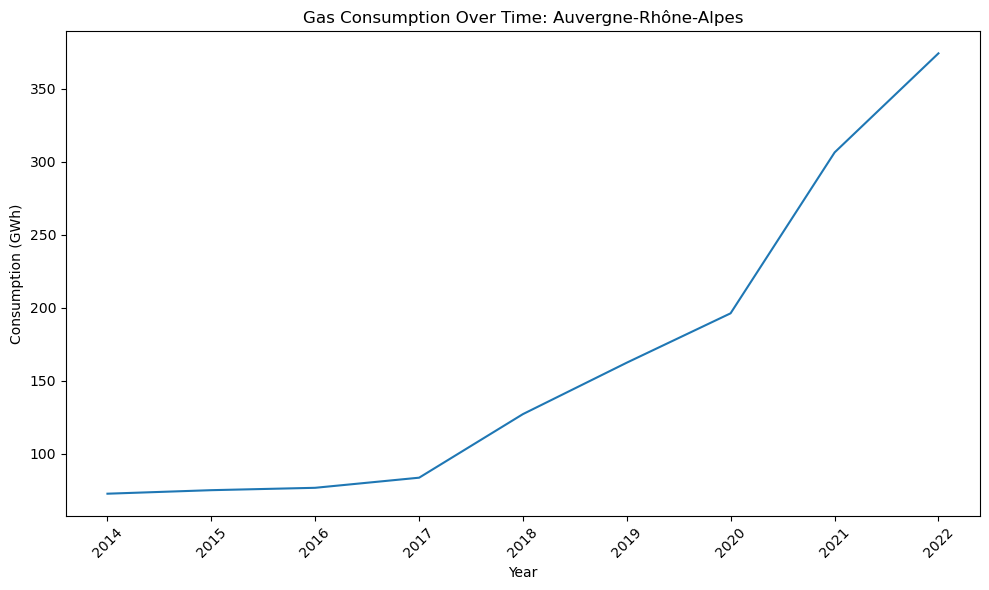

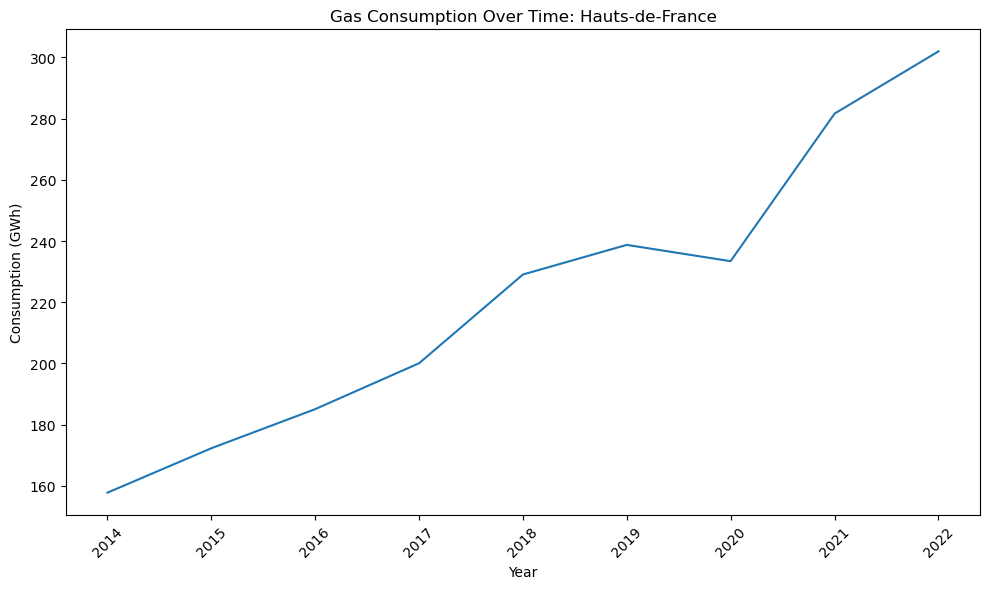

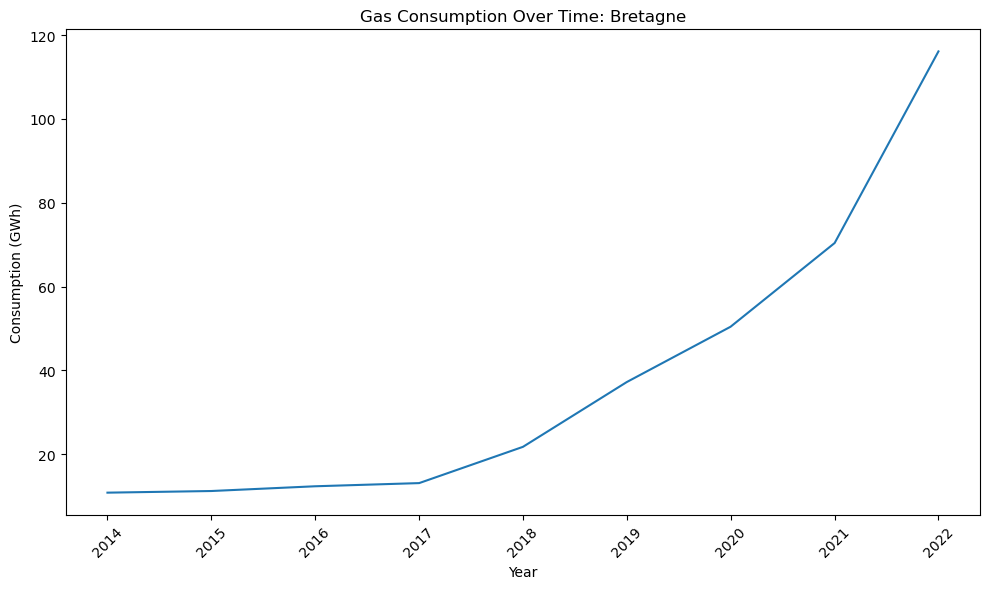

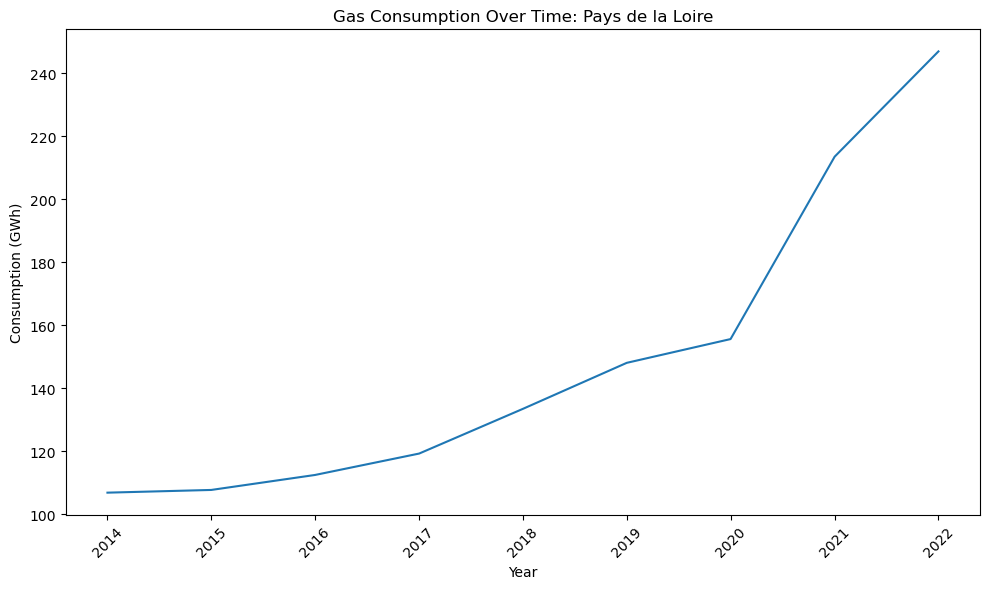

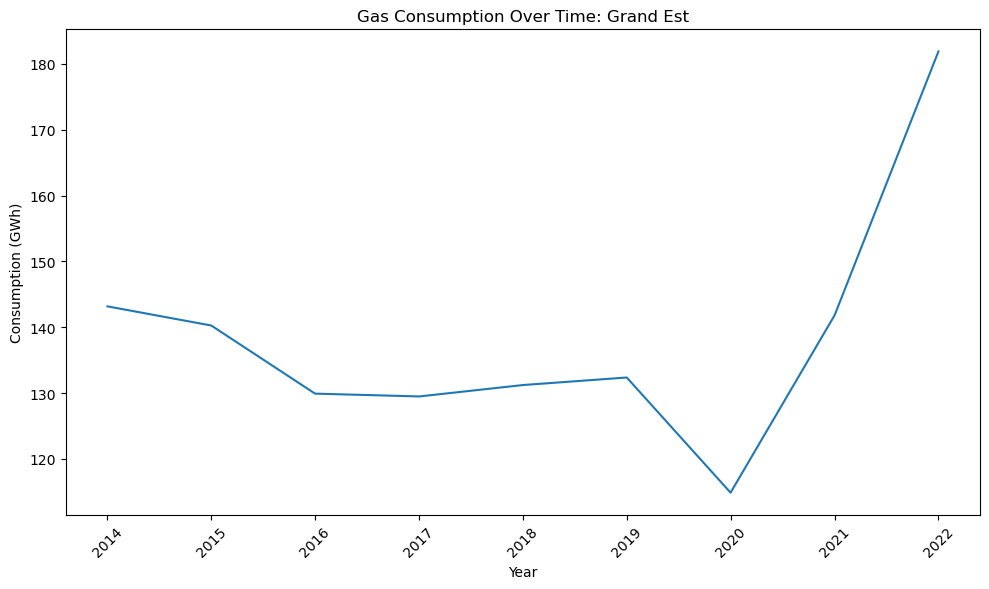

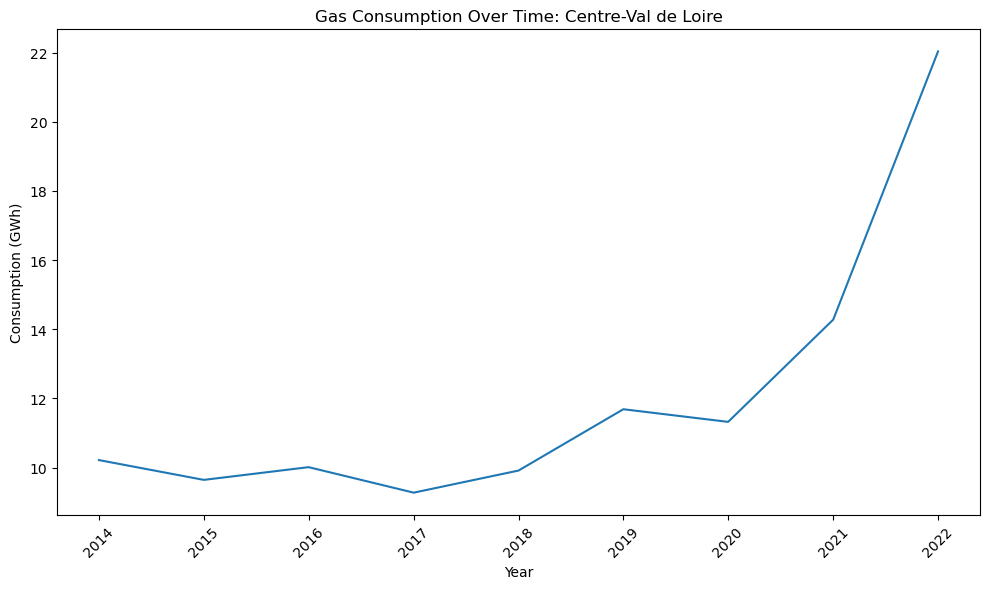

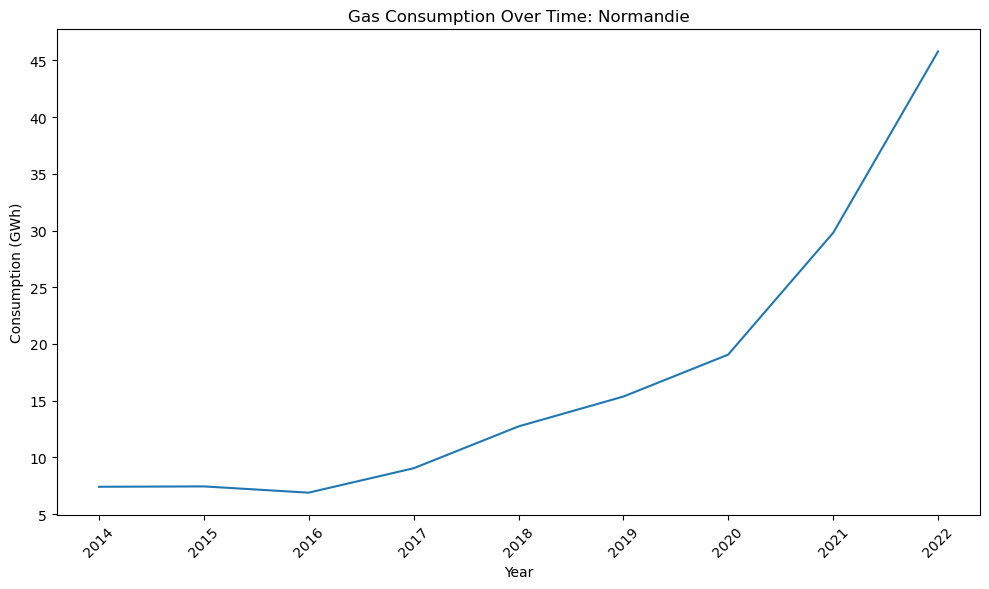

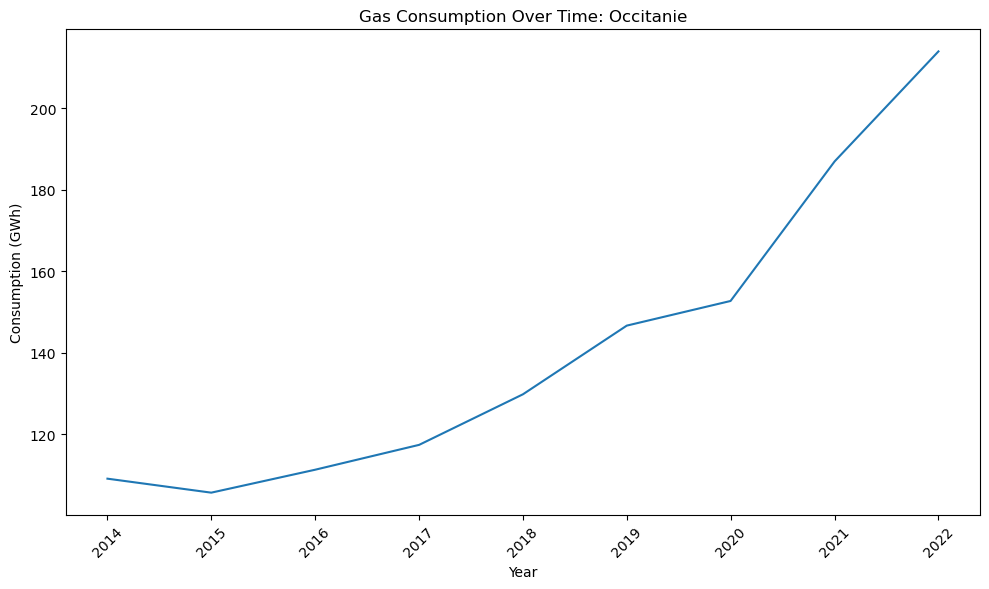

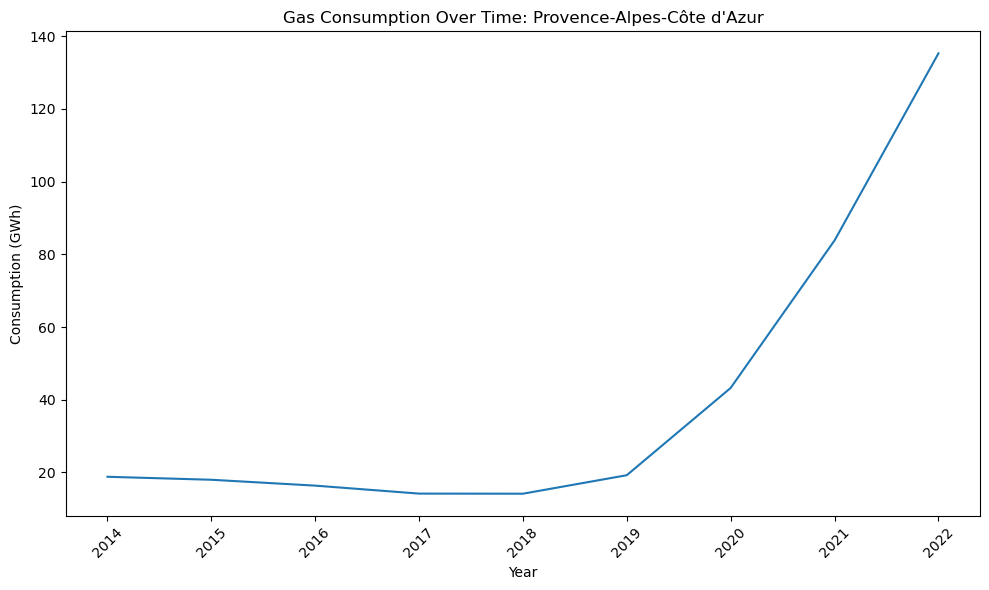

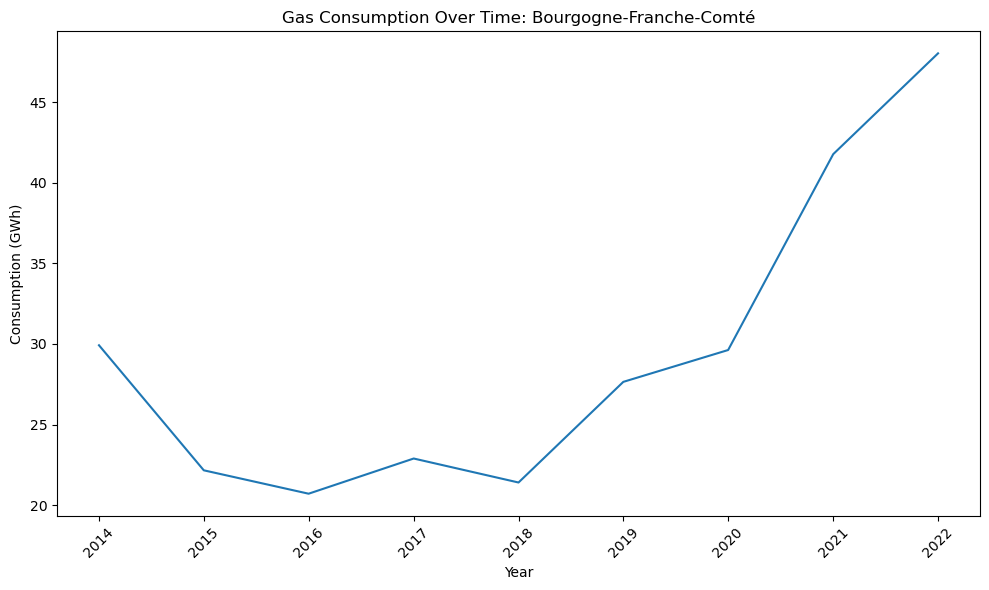

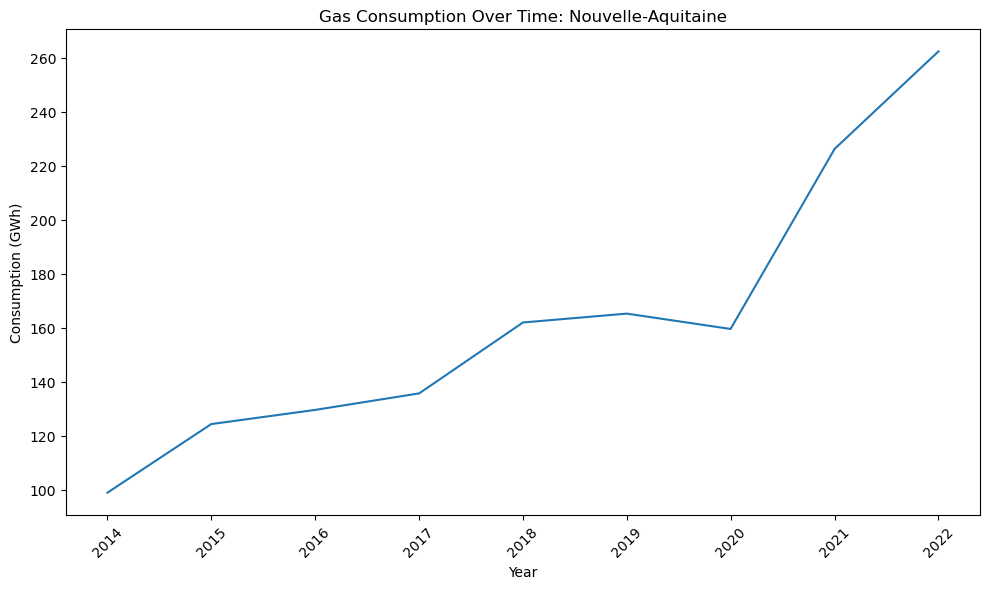

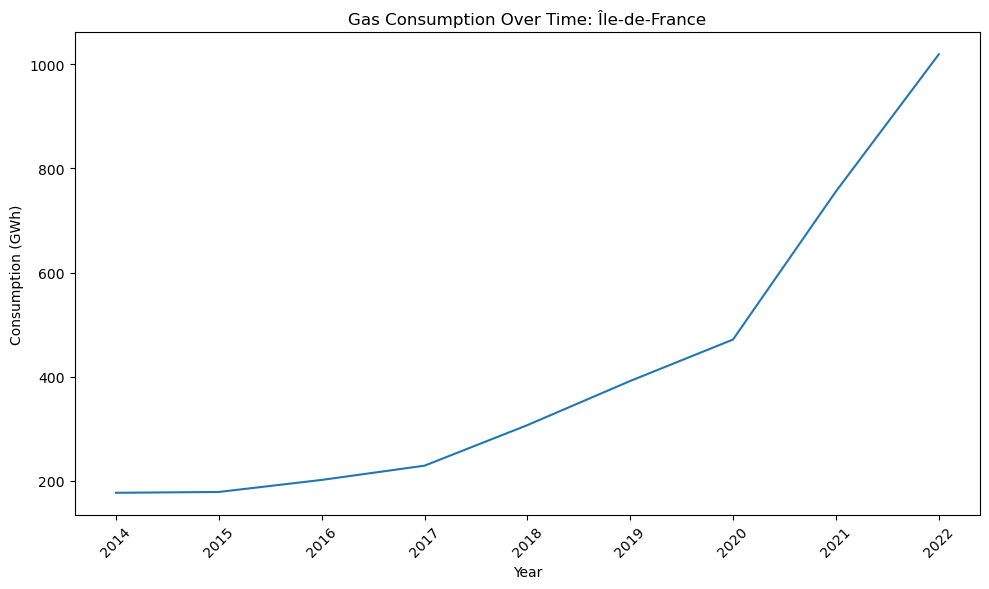

In [18]:
# 4 Time series analysis by region
for region in gdf['region'].unique():
    region_data = gdf[gdf['region'] == region].sort_values('annee')
    plt.figure(figsize=(10, 6))
    plt.plot(region_data['annee'], region_data['consommation_gwh_pcs'])
    plt.title(f'Gas Consumption Over Time: {region}')
    plt.xlabel('Year')
    plt.ylabel('Consumption (GWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()